In [47]:
import glob
import random
import re
import nltk
nltk.download('stopwords')
!pip3 install stemming
from stemming.porter2 import stem
from nltk.corpus import stopwords
import string

# Spectral clustering
import numpy as np
import pandas as pd
import csv
import sklearn
from sklearn import cluster
import networkx as nx
import scipy
from scipy.sparse.linalg import eigs, eigsh
import matplotlib
from matplotlib import pylab
from matplotlib import pyplot as plt

# Community detection
import json

# Sentiment Analysis 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.8)
import collections

/Users/jiayizhang/.zshenv:2: command not found: rbenv


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jiayizhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Read Music CDs customer review file
df = pd.read_json("Digital_Music.json", lines=True)

# Get the size of the dataset
len(df)

1584082

In [8]:
# Generate English stopwords
sws = set(stopwords.words('english'))

In [9]:
# Music related stopwords and words that are frequent in reivews but generally not helpful for sentiment analysis 
topic_related_sws = {"song", "songs", "album", "music", "sound", "voice", 
                     "listen", "could", "would", "get", "time", "heard",
                    "band", "hear", "heard", "lyrics", "version", "track",
                    "rock", "version", "ve", "one", "new", "old", "still",
                    "singer", "vibe", "jazz", "vocal", "voices", "much", 
                     "hip hop", "drum", "melody", "opera", "beats", "chord",
                    "back", "even", "also", "culture", "many", "years",
                    "classic", "think", "listening", "first", "tracks", "got",
                    "ever", "fan", "fans", "make", "way", "sounds", "metal"}

In [10]:
# Get all review text
all_docs = df['reviewText'].values

In [11]:
# Sentiment Analysis
# Remove English stopwords, words of insig length, and links
sid = SentimentIntensityAnalyzer()
exclude = set(string.punctuation)
review = []
scores = []

for n, doc in enumerate(all_docs):
    tokens = nltk.word_tokenize(str(doc).lower())
    parsed_tokens = [i for i in tokens 
                        if i not in sws   # drop stopwords 
                             and len(i) > 2  # drop words of insig length
                             and (not i.startswith("http")) # drop links
                             and i not in exclude # drop punctuations
                             and i not in topic_related_sws] #drop music related stopwords
    parsed_sentence = ' '.join(parsed_tokens)
    review += [parsed_sentence]
#     print('SENTENCE {} WITHOUT STOPWORDS: {}'.format(n, parsed_sentence))

    data = sid.polarity_scores(parsed_sentence)
#     for k in sorted(data):
#         print('{0}: {1}, '.format(k, data[k]), end='')
#     print()
    
    data['review'] = parsed_sentence
    scores += [data]

In [12]:
len(scores)

1584082

In [13]:
# Create data frame
dataFrame = pd.DataFrame(scores)

# Create data frame with label
def label_sentiment(row):
    cutoff = .5
    if row.compound < -1 * cutoff:
        return "neg"
    elif row.compound > cutoff:
        return "pos"
    else:
        return "neu"
    

dataFrame["label"] = dataFrame.apply(label_sentiment, axis=1)
dataFrame.head()

,neg,neu,pos,compound,review,label
0,0.000,0.187,0.813,0.9545,great full worship favorites great keith green...,pos
1,0.000,0.284,0.716,0.8779,creative love words message favorite bought ago,pos
2,0.000,0.749,0.251,0.7717,keith green gone far early carreer left golden...,pos
3,0.000,0.498,0.502,0.8442,keith green special comedy style chirstian pow...,pos
4,0.045,0.484,0.471,0.9062,keith green wan egypt ... keith gets serious m...,pos


In [14]:
avg_sentiment_score = sum(dataFrame['compound'])/len(dataFrame['compound'])
print("The average sentiment score is ", round(avg_sentiment_score,2))

The average sentiment score is  0.61


In [15]:
pos = dataFrame[dataFrame.label=="pos"]
len(pos)

1161501

In [16]:
neg = dataFrame[dataFrame.label=="neg"]
len(neg)

29464

In [17]:
neu = dataFrame[dataFrame.label=="neu"]
len(neu)

393117

In [18]:
pos_percentage = len(pos) / len(scores)
print("% of positive review is ", round(pos_percentage,2))

% of positive review is  0.73


In [19]:
neg_percentage = len(neg) / len(scores)
print("% of negative review is ", round(neg_percentage,2))

% of negative review is  0.02


In [20]:
neu_percentage = len(neu) / len(scores)
print("% of neutral review is ", round(neu_percentage,2))

% of neutral review is  0.25


In [21]:
positive_scores_sum = sum(dataFrame[dataFrame.label=="pos"].compound)
print("The average positive score is ", round(positive_scores_sum/len(pos),2))

The average positive score is  0.79


In [22]:
negative_scores_sum = sum(dataFrame[dataFrame.label=="neg"].compound)
print("The average negative score is ", round(negative_scores_sum/len(neg),2))

The average negative score is  -0.68


In [23]:
neutral_scores_sum = sum(dataFrame[dataFrame.label=="neu"].compound)
print("The average neutral score is ", round(neutral_scores_sum/len(neu),2))

The average neutral score is  0.17


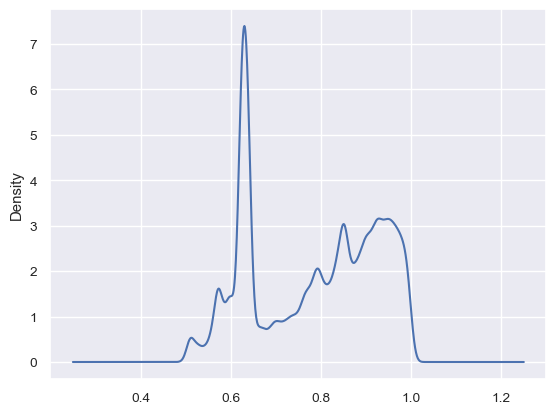

In [24]:
# Kernel Density Estimatation graph for pos sentiment
dataFrame[dataFrame.label=="pos"].compound.plot.kde();

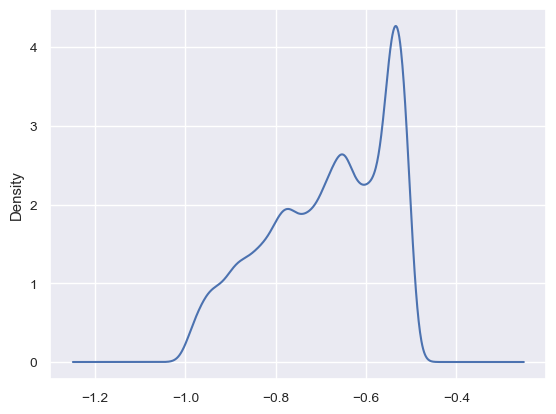

In [25]:
# Kernel Density Estimatation graph for neg sentiment
dataFrame[dataFrame.label=="neg"].compound.plot.kde();

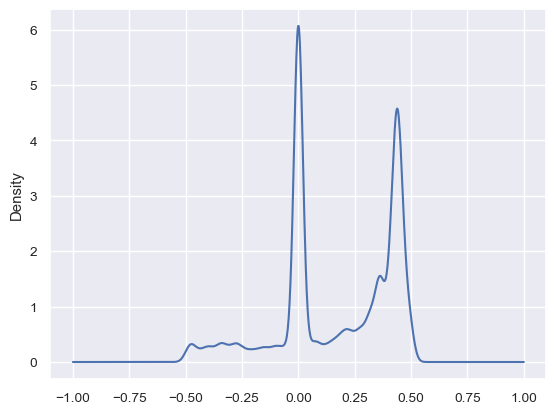

In [26]:
# Kernel Density Estimatation graph for neu sentiment
dataFrame[dataFrame.label=="neu"].compound.plot.kde();

/Users/jiayizhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


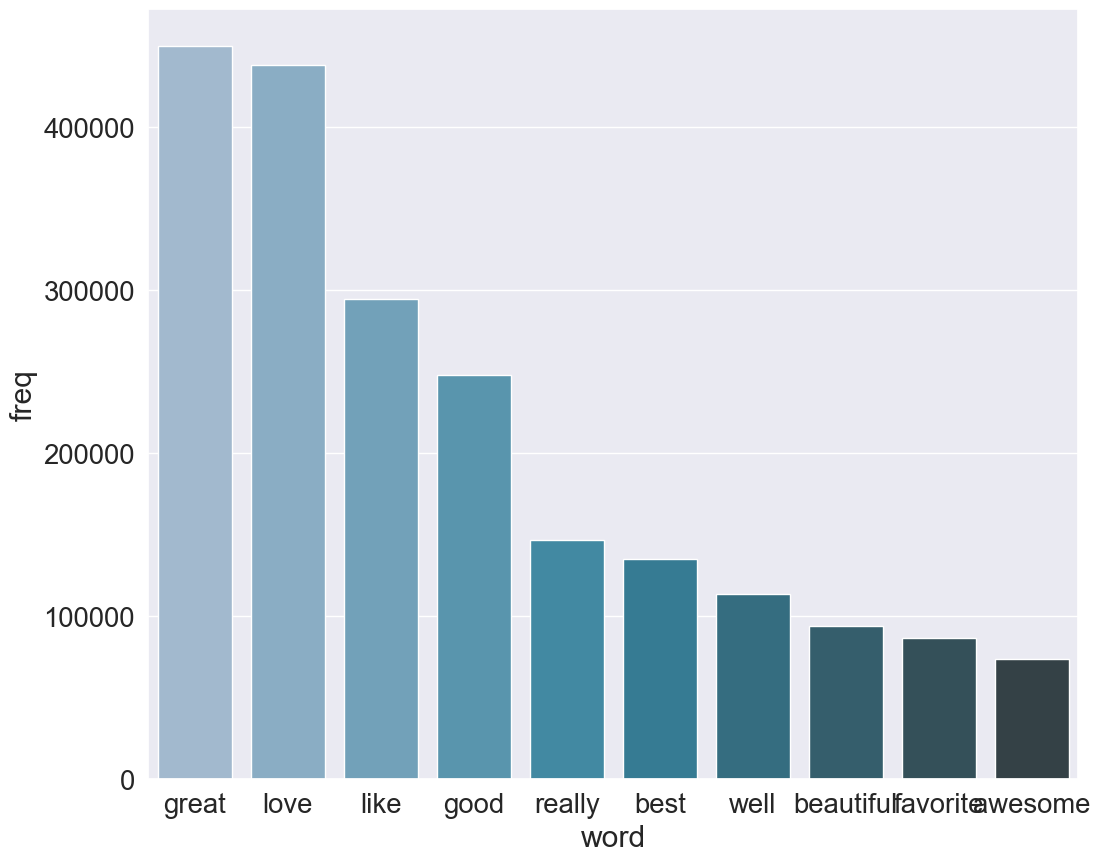

In [48]:
# Most frequent words in all reviews
# Reference: Carremans, B. (2019, January 8). Sentiment analysis with text mining. Medium. Retrieved May 5, 2023, 
# from https://towardsdatascience.com/sentiment-analysis-with-text-mining-13dd2b33de27 
cv = CountVectorizer()
bow = cv.fit_transform(review)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(10), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

In [28]:
# Get positive, negative, and neutral reviews separately 
pos_reviews = pos['review']
neg_reviews = neg['review']
neu_reviews = neu['review']

/Users/jiayizhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


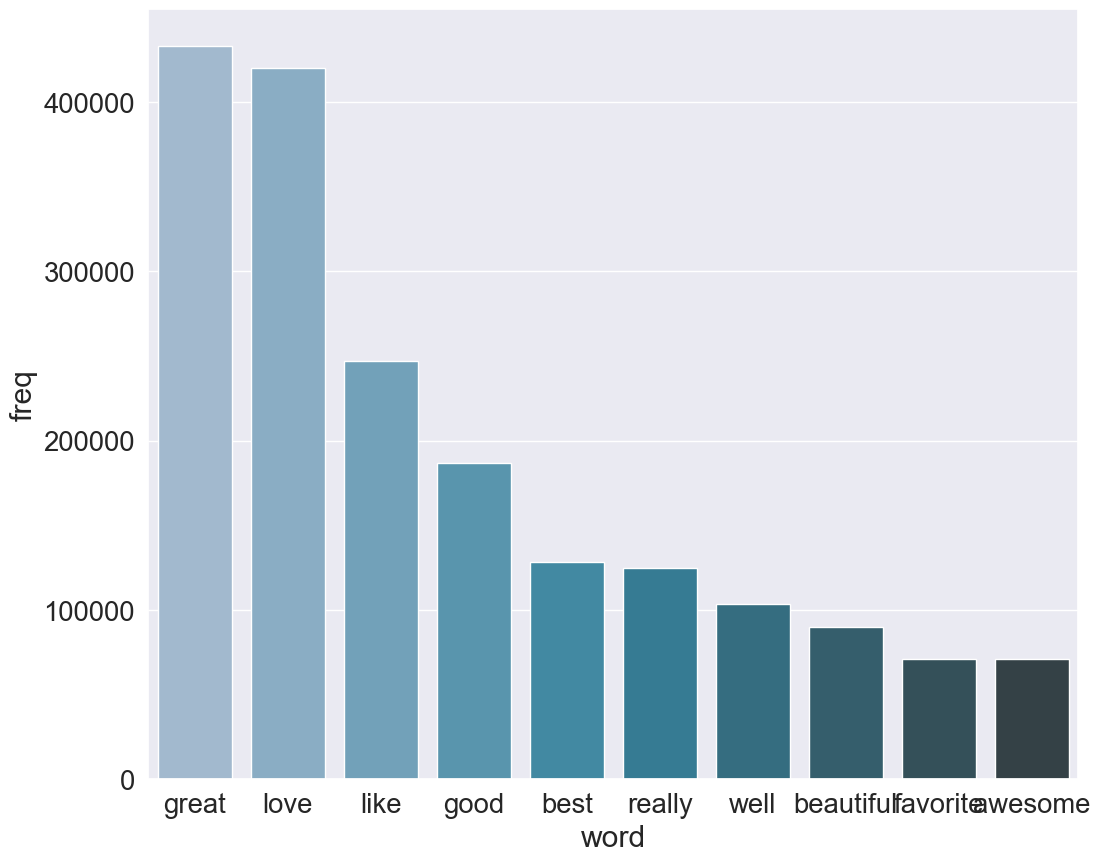

In [49]:
# Most frequent words in pos reviews
# Reference: Carremans, B. (2019, January 8). Sentiment analysis with text mining. Medium. Retrieved May 5, 2023, 
# from https://towardsdatascience.com/sentiment-analysis-with-text-mining-13dd2b33de27 
cv = CountVectorizer()
bow = cv.fit_transform(pos_reviews)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(10), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

/Users/jiayizhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


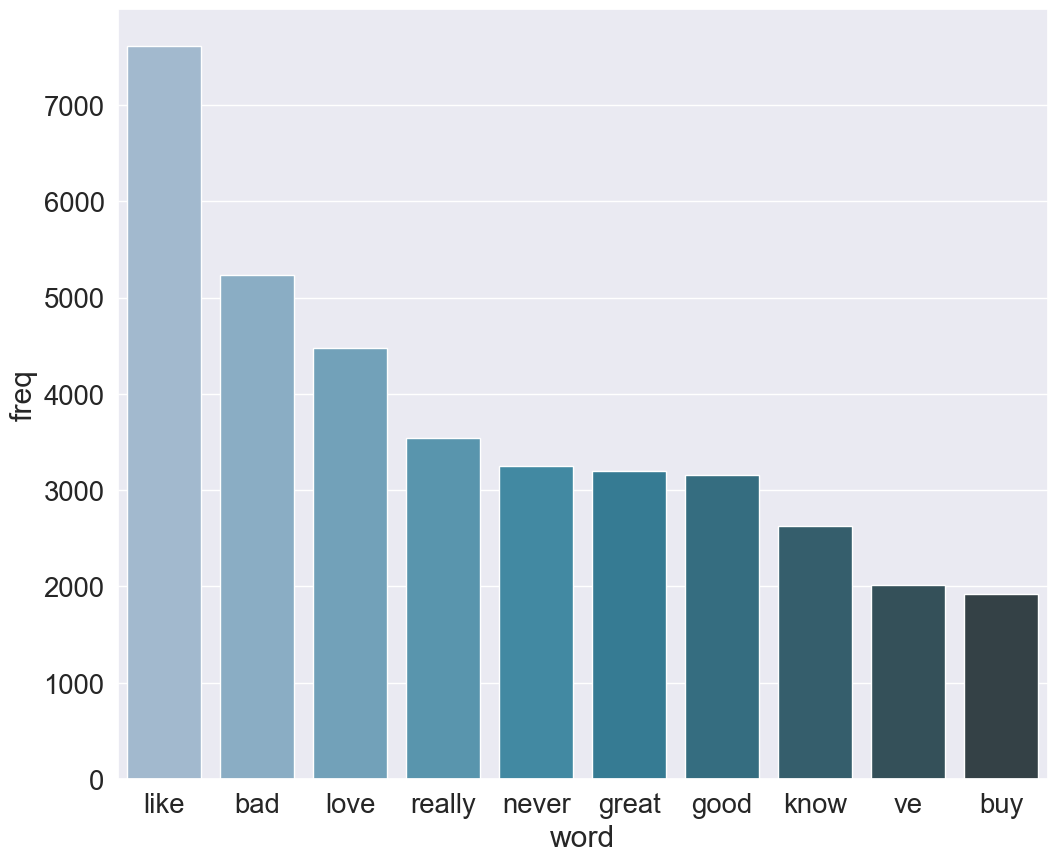

In [50]:
# Most frequent words in neg reviews
# Reference: Carremans, B. (2019, January 8). Sentiment analysis with text mining. Medium. Retrieved May 5, 2023, 
# from https://towardsdatascience.com/sentiment-analysis-with-text-mining-13dd2b33de27 
cv = CountVectorizer()
bow = cv.fit_transform(neg_reviews)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(10), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

/Users/jiayizhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


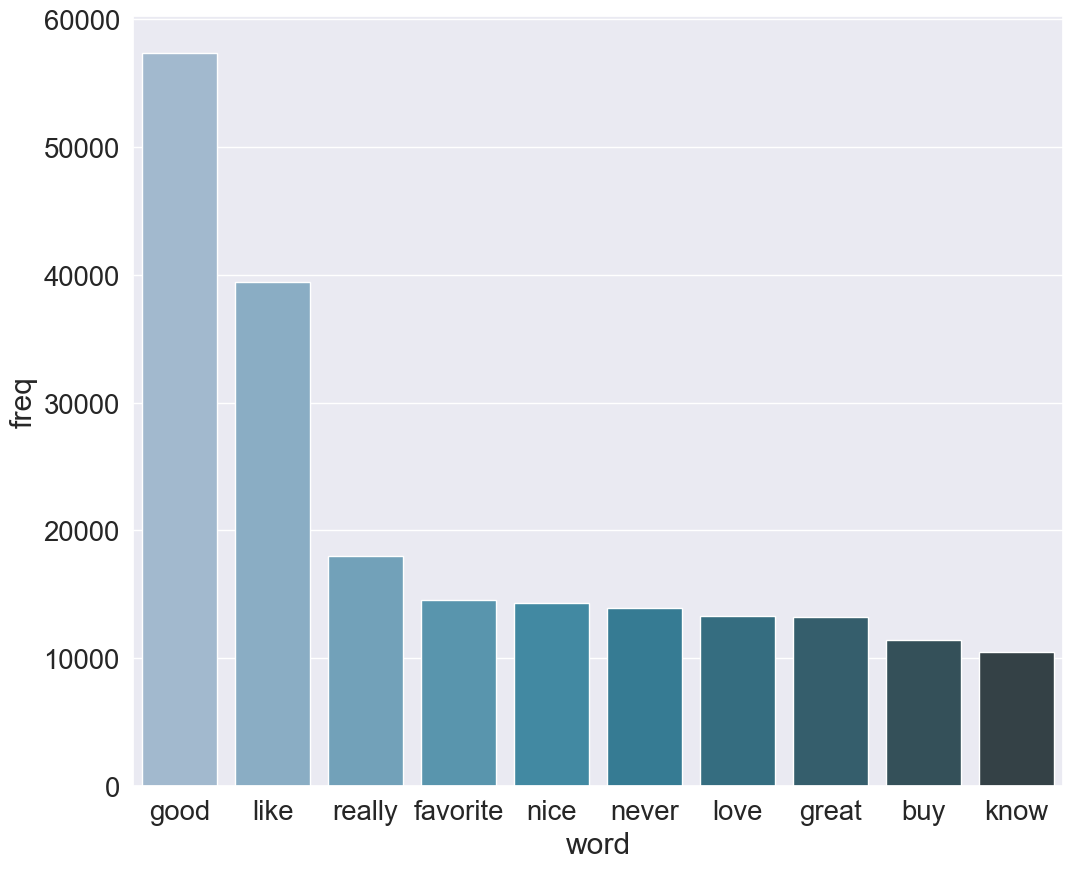

In [51]:
# Most frequent words in neu reviews
# Reference: Carremans, B. (2019, January 8). Sentiment analysis with text mining. Medium. Retrieved May 5, 2023, 
# from https://towardsdatascience.com/sentiment-analysis-with-text-mining-13dd2b33de27 
cv = CountVectorizer()
bow = cv.fit_transform(neu_reviews)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(10), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

In [32]:
# Find reviews where neutral score is higher than positive or negative
compare_reviews = dataFrame.where((dataFrame['neu'] > dataFrame['pos']) & (
    dataFrame['neu'] > dataFrame['neg']))


compare_reviews = compare_reviews[~compare_reviews['label'].isnull()]


compare_reviews.head(10)

,neg,neu,pos,compound,review,label
2,0.000,0.749,0.251,0.7717,keith green gone far early carreer left golden...,pos
4,0.045,0.484,0.471,0.9062,keith green wan egypt ... keith gets serious m...,pos
6,0.307,0.439,0.254,-0.1531,tape hardly understood listed sale good bad,neu
7,0.096,0.707,0.197,0.9325,keith green bit legend christian circles profo...,pos
9,0.000,1.000,0.000,0.0000,buy buy mp3 download longer available n't find...,neu
10,0.000,1.000,0.000,0.0000,takes childhood,neu
15,0.000,0.723,0.277,0.3182,original protective packaging makes used inste...,neu
18,0.000,1.000,0.000,0.0000,younger musician used quite often church,neu
22,0.266,0.516,0.218,-0.4114,awesome though rise haunted unfortunately sub-...,neu
23,0.000,1.000,0.000,0.0000,bought early works rise saw lord husband sung ...,neu


In [38]:
# Obtain lists of pos, neg, and neu words in one of the sentences 
pos_words = []
neg_words =[]
neu_words =[]

review_text = dataFrame.iloc[6]["review"]

words = nltk.word_tokenize(review_text)

for word in words:
    if (sid.polarity_scores(word)['compound']) >= 0.5:
        pos_words.append(word)
    elif (sid.polarity_scores(word)['compound']) <= -0.5:
        neg_words.append(word)
    else:
        neu_words.append(word)  

print(review_text)
print('Positive ->',pos_words)        
print('Neutral ->:',neu_words)    
print('Negative ->',neg_words)  

tape hardly understood listed sale good bad
Positive -> []
Neutral ->: ['tape', 'hardly', 'understood', 'listed', 'sale', 'good']
Negative -> ['bad']


In [39]:
count = len(pos_words) + len(neg_words) + len(neu_words)
count

7

In [40]:
pos_perc = len(pos_words)/count
print("% of positive words is ", round(pos_perc,2))

% of positive words is  0.0


In [41]:
neg_perc = len(neg_words)/count
print("% of negative words is ", round(neg_perc,2))

% of negative words is  0.14


In [42]:
neu_perc = len(neu_words)/count
print("% of neutral words is ", round(neu_perc,2))

% of neutral words is  0.86
